In [45]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import utils.ssvep_analysis as sa

In [46]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()
    match = re.search(r'Severity:\s*(\d+(\.\d+)?)', content)
    severity = float(match.group(1))
    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    return eeg_data, severity

def preprocess_data(eeg_data):
    eeg_data = sa.apply_ransac_detrending(eeg_data)
    eeg_data = sa.filter_extreme_values(eeg_data)
    eeg_data = sa.apply_highpass_filter(eeg_data)
    eeg_data = sa.apply_lowpass_filter(eeg_data)
    eeg_data = sa.apply_notch_filter(eeg_data)
    return eeg_data

def process_file(file_path):
    eeg_data, severity = read_data(file_path)
    eeg_data = preprocess_data(eeg_data)
    cca, _ = sa.compute_cca(eeg_data)
    coefs = cca.coef_
    coefs = np.sqrt(np.sum(coefs**2, axis=0))
    coefs = coefs / np.sqrt(np.sum(coefs**2))
    return [severity] + list(coefs)

def process_directory(directory_path):
    coefs_list = []
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        coefs = process_file(file_path)
        coefs_list.append(coefs)
    df = pd.DataFrame(coefs_list)
    return df

def process_directory_list(directory_list):
    df_list = []
    for directory in directory_list:
        df_list.append(process_directory('../data/' + directory))
    df = pd.concat(df_list)
    return df

directory_list = ['2024-01-12', '2024-01-19', '2024-01-22']
df = process_directory_list(directory_list)

In [56]:
df.columns = ['severity', 'PO7', 'O1', 'PO3', 'Oz', 'Pz', 'O2', 'PO4', 'PO8']
print(df.shape)
df.head()

(92, 9)


,severity,PO7,O1,PO3,Oz,Pz,O2,PO4,PO8
0,0.0,0.049826,0.343302,0.083695,0.503495,0.219349,0.483078,0.185519,0.550685
1,0.0,0.029745,0.220299,0.545966,0.611138,0.025774,0.313211,0.084029,0.416161
2,0.0,0.008983,0.170308,0.201254,0.396554,0.310862,0.591535,0.215016,0.529505
3,0.0,0.103916,0.052359,0.231732,0.759389,0.251488,0.008775,0.176547,0.511466
4,0.0,0.051726,0.001987,0.190641,0.141942,0.262890,0.824212,0.062289,0.434179


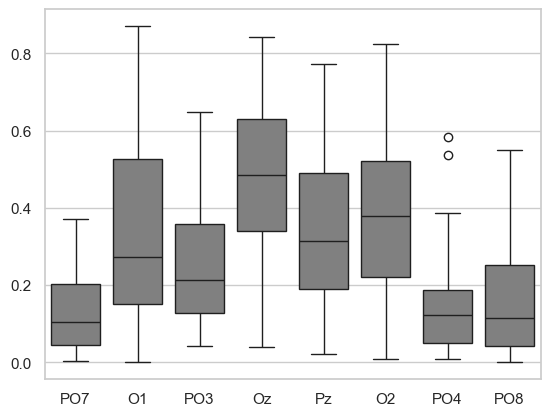

In [57]:
sns.boxplot(data=df[df['severity'] == 0][['PO7', 'O1', 'PO3', 'Oz', 'Pz', 'O2', 'PO4', 'PO8']], color='grey');

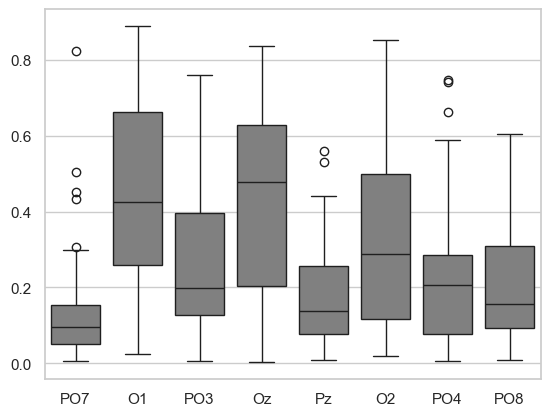

In [58]:
sns.boxplot(data=df[df['severity'] > 0.5][['PO7', 'O1', 'PO3', 'Oz', 'Pz', 'O2', 'PO4', 'PO8']], color='grey');